In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import math
import seaborn as sns
import datetime as dt
%matplotlib inline
start_time = pd.datetime.now()

In [2]:
mydata = pd.read_excel('card transactions.xlsx', converters={'Merchnum': lambda x: str(x)})

In [3]:
mydata.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


In [4]:
#get the first none-zero digit in a number
def first_nonzero_digit(x):
    for i in range(len(x)):
        if x[i] in ['0', '.', ' ']:
            continue
        else:
            break
    return(x[i])

In [5]:
#get n_high for each group
def n_high(df, num, num_type):
    if num_type == 'Cardnum':
        tempdf = df[df['Cardnum'] == num]
    else:
        tempdf = df[df['Merchnum'] == num]
    return(len(tempdf[tempdf['Amount_first_digit'] > '2']))

In [6]:
#get n_low for each group
def n_low(df, num, num_type):
    if num_type == 'Cardnum':
        tempdf = df[df['Cardnum'] == num]
    else:
        tempdf = df[df['Merchnum'] == num]
    return(len(tempdf[tempdf['Amount_first_digit'] <= '2']))

In [7]:
def create_mapping(df):
    summary = pd.DataFrame(df[['Merch description', 'Merchnum', 'Recnum']].\
                             groupby(['Merch description','Merchnum']).count()['Recnum'].reset_index(name = 'Count'))
    return summary

In [8]:
def fill_merch_num(merch_description):
    temp_df = summary[(summary['Merch description'] == merch_description)].sort_values(by = "Count", ascending = False)
    
    if temp_df.shape[0] > 0:
        num = list(temp_df["Merchnum"])[0]
        return(num)

# Data Cleaning

In [9]:
#remove one outlier in the dataset
mydata = mydata.drop(index = 52714)
len(mydata)

96752

In [10]:
#exclude non-purchase transaction types
mydata = mydata[mydata["Transtype"] == "P"].reset_index(drop = True)
len(mydata)

96397

In [11]:
#fill in missing values for merchant number with the mode of descriptions
##replace all 0s with Null values
mydata["Merchnum"] = mydata["Merchnum"].apply(lambda x: None if x == "0" else x)

summary = create_mapping(mydata)
null_num = mydata.loc[mydata["Merchnum"].isnull(),['Merch description']]
for index in null_num.index:
    mydata.loc[index, "Merchnum"] = fill_merch_num(mydata.loc[index, "Merch description"])

In [12]:
#fill in the remaining missing values for merchant number
merchnum_missing = list(mydata[mydata["Merchnum"].isnull() == True].index)
for index in merchnum_missing:
     mydata.loc[index, "Merchnum"] = -index

In [13]:
#fill in missing values for merchant zip
zip_missing = list(mydata[mydata["Merch zip"].isnull() == True].index)
for index in zip_missing:
     mydata.loc[index, "Merch zip"] = -index

In [14]:
#fill in missing values for merchant state
state_missing = list(mydata[mydata["Merch state"].isnull() == True].index)
for index in state_missing:
     mydata.loc[index, "Merch state"] = -index

In [15]:
#fix frivolous values
mydata['Merch zip'] = mydata['Merch zip'].astype(str)
mydata['Cardnum'] = mydata['Cardnum'].astype(str)
mydata['Merchnum'] = mydata['Merchnum'].astype(str)
mydata["Merch state"] = mydata["Merch state"].astype(str)
mydata['Amount'] = mydata['Amount'].astype(float)

## Variable Creation

In [16]:
#combine related fields
mydata["Cardnum-Merch"] = mydata["Cardnum"] + mydata["Merchnum"]
mydata["Cardnum-Zip"] = mydata["Cardnum"] + mydata["Merch zip"]
mydata["Cardnum-State"] = mydata["Cardnum"] + mydata["Merch state"]

In [17]:
#keep useful fields for variable creation
attributes = list(mydata.columns)
for col in ['Recnum', 'Date', 'Amount', 'Merch description', 'Merch state', 'Merch zip', 'Transtype', 'Fraud']:
    attributes.remove(col)
attributes

['Cardnum', 'Merchnum', 'Cardnum-Merch', 'Cardnum-Zip', 'Cardnum-State']

In [18]:
finalDF = mydata[['Recnum','Date','Amount']]

for val in attributes:
    df1 = mydata[['Recnum','Date', 'Amount', val]].copy()
    df2 = df1.copy()
    lags = [0, 1, 3, 7, 14, 30]
    
    for lag in lags:
        temp_name = 'Date_{}'.format(lag)
        df2[temp_name] = df2['Date'] + dt.timedelta(lag)

    dff = df1.merge(df2, on = val)
    
    #create #days_since variables
    tmp = dff[(dff['Recnum_x'] > dff['Recnum_y'])][['Recnum_x','Date_y']].\
          groupby('Recnum_x').last()['Date_y'].reset_index()
    
    tmp.columns = ['Recnum','last_seen']
    df1 = df1.merge(tmp, how = 'left', on = 'Recnum')
    df1['#days_since'] = df1['Date'] - df1['last_seen']
    df1['#days_since'] = df1['#days_since'].dt.days
    df1['#days_since_start'] = (df1['Date'] - df1['Date'].min()).dt.days
    df1['#days_since'] = df1['#days_since'].fillna(df1['#days_since_start'])
    
    df1.drop(columns = ['last_seen','#days_since_start'], inplace = True)
    
    #create amount and frequency variables
    for lag in lags:
        temp = dff[(dff['Recnum_x'] >= dff['Recnum_y']) & (dff['Date_x'] <= dff['Date_{}'.format(lag)])]
        temp_agg = temp[['Recnum_x','Amount_y']].groupby('Recnum_x').agg(['count', 'mean', 'max', 'median', 'sum']).reset_index()
        temp_name = ['lag{}_count'.format(lag), 'lag{}_average'.format(lag), 'lag{}_max'.format(lag), 'lag{}_median'.format(lag), 'lag{}_total'.format(lag)]
        temp_agg.columns = ['Recnum'] + temp_name
        
        temp_agg['lag{}_actual/avg'.format(lag)] = mydata["Amount"]/temp_agg['lag{}_average'.format(lag)]
        temp_agg['lag{}_actual/max'.format(lag)] = mydata["Amount"]/temp_agg['lag{}_max'.format(lag)]
        temp_agg['lag{}_actual/median'.format(lag)] = mydata["Amount"]/temp_agg['lag{}_median'.format(lag)]
        temp_agg['lag{}_actual/total'.format(lag)] = mydata["Amount"]/temp_agg['lag{}_total'.format(lag)]
        
        df1 = df1.merge(temp_agg, how = 'left', on = 'Recnum')
        
    df1.drop(columns = ['Date', val], inplace = True)
    df1 = df1.set_index('Recnum')
    df1 = df1.add_prefix('{}_'.format(val))
    finalDF = finalDF.merge(df1, how = 'left', on = 'Recnum')
    finalDF.drop(labels = "{}_Amount".format(val), axis = 1, inplace = True)
    

In [19]:
#create velocity variables for counts
core = ['Cardnum', 'Merchnum']
for val in core:
    for i in [0, 1]:
        for j in [7, 14, 30]:
            temp_name = '{}_lag{}_lag{}_avg_count'.format(val,i,j)
            numerator = '{}_lag{}_count'.format(val,i)
            denominator = '{}_lag{}_count'.format(val,j)
            finalDF[temp_name] = finalDF[numerator] / (finalDF[denominator]/j)

In [20]:
#create velocity variables for amount
for val in core:
    for i in [0, 1]:
        for j in [7, 14, 30]:
            temp_name = '{}_lag{}_lag{}_avg_amount'.format(val,i,j)
            numerator = '{}_lag{}_total'.format(val,i)
            denominator = '{}_lag{}_total'.format(val,j)
            finalDF[temp_name] = finalDF[numerator] / (finalDF[denominator]/j)

In [21]:
#create weekday risk variable
finalDF["weekday"] = finalDF["Date"].dt.dayofweek
finalDF = finalDF.merge(mydata[["Recnum", "Fraud"]])

In [22]:
#calculate weekday fraud
c = 3
nmid = 15
y_avg = finalDF["Fraud"].mean()
y_weekday_avg = finalDF.groupby("weekday").mean()["Fraud"]
num_instances_weekday = finalDF.groupby("weekday").size()
y_weekday_smooth = y_avg + (y_weekday_avg - y_avg)/(1 + np.exp(-(num_instances_weekday-nmid)/c))
finalDF["weekday_risk"] = finalDF["weekday"].map(y_weekday_smooth)

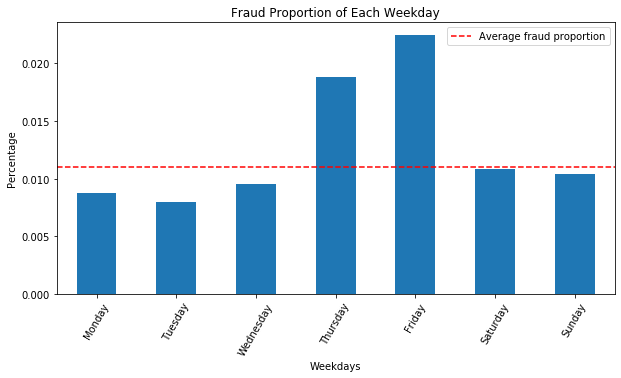

In [23]:
#plot weekday risks
plt.figure(figsize=(10,5))
y_weekday_smooth.plot(kind = 'bar')
plt.xticks(range(7),
           ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
           rotation=60)
plt.axhline(y_avg, color='r', linestyle='--')
plt.xlabel('Weekdays')
plt.ylabel('Percentage')
plt.title('Fraud Proportion of Each Weekday')
plt.legend(['Average fraud proportion'])
plt.show()

## Remove All Transactions From Fedex

In [24]:
mydata['Merch description'] = mydata['Merch description'].apply(lambda x: x.lower())

In [25]:
mydata_copy = mydata.copy()
mydata_copy['result'] = mydata_copy['Merch description'].str.findall(r'fed')
mydata_copy['result'] = mydata_copy['result'].apply(lambda x: "null" if x == [] else x)
fed_result = mydata_copy[mydata_copy['result'] != "null"].groupby("Merch description")['Recnum'] \
                                                         .count() \
                                                         .reset_index(name = 'count') \
                                                         .sort_values(['count'], ascending = False)

In [26]:
#extract all "fedex shp|fedex|federal express" related records
fed_result['flag'] = fed_result['Merch description'].str.findall(r'\bfedex\b|\bfederal express\b|\bfed ex #16\b')
fed_result['flag'] = fed_result['flag'].apply(lambda x: 0 if x == [] else 1)

fedex_namelist = fed_result[fed_result['flag'] == 1]['Merch description'].values.tolist()
#add 'fedex danger gds seminar' back since it is not related to fed ex
fedex_namelist.remove('fedex danger gds seminar')

In [27]:
#get rid of all fedex records in the dataset
mydata_copy['Merch description'] = mydata_copy['Merch description'].apply(lambda x: 1 if x in fedex_namelist else x)
mydata_copy = mydata_copy[mydata_copy['Merch description'] != 1]
len(mydata_copy)

84581

## Benford's Law Variables

In [28]:
#get storing the first digits of card number and merchant number
mydata_copy['Amount'] = mydata_copy['Amount'].astype(str)
mydata_copy['Amount_first_digit'] = mydata_copy['Amount']
mydata_copy['Amount_first_digit'] = mydata_copy['Amount_first_digit'].apply(lambda x: first_nonzero_digit(x))

In [29]:
benford_data = mydata_copy.copy()

In [30]:
#Cardnum table
card_table = benford_data.groupby(["Cardnum"])["Recnum"].count().reset_index(name = "n")

In [31]:
#for each card number group, calculate nhigh and nlow
card_table['n_high'] = [0]*len(card_table)
card_table['n_low'] = [0]*len(card_table)

for i in range(len(card_table)):
    card_table.loc[i, 'n_high'] = n_high(benford_data, card_table.loc[i, 'Cardnum'], 'Cardnum')
    card_table.loc[i, 'n_low'] = n_low(benford_data, card_table.loc[i, 'Cardnum'], 'Cardnum')

In [32]:
#get rid of 0 values
card_table["n_high"] = card_table["n_high"].apply(lambda x: 1 if x == 0 else x)
card_table["n_low"] = card_table["n_low"].apply(lambda x: 1 if x == 0 else x)

In [33]:
#create R and 1/R
card_table["R"] = 1.096*card_table['n_low']/card_table['n_high']
card_table["1/R"] = 1/card_table["R"]

In [34]:
#calculate t
card_table['t'] = [0]*len(card_table)

for i in range(len(card_table)):
    card_table.loc[i, 't'] = -(15 - card_table.loc[i, "n"])/3

In [35]:
#calculate U and U*
card_table['U'] = [0]*len(card_table)
card_table['U*'] = [0]*len(card_table)

for i in range(len(card_table)):
    card_table.loc[i, "U"] = max(card_table.loc[i, "R"], card_table.loc[i, "1/R"])
    card_table.loc[i, "U*"] = 1 + (card_table.loc[i, "U"] - 1)/(1 + math.exp((15 - card_table.loc[i, "n"])/3))

card_table.sort_values(by = 'U*', ascending = False, inplace = True)
card_table.head()

,Cardnum,n,n_high,n_low,R,1/R,t,U,U*
1177,5142253356,66,5,61,13.371200,0.074788,17.000000,13.371200,13.371199
1541,5142299705,28,3,25,9.133333,0.109489,4.333333,9.133333,9.027976
725,5142197563,149,134,15,0.122687,8.150852,44.666667,8.150852,8.150852
697,5142194617,38,33,5,0.166061,6.021898,7.666667,6.021898,6.019548
1449,5142288241,14,13,1,0.084308,11.861314,-0.333333,11.861314,5.533836


In [36]:
#Merchnum table
merch_table = benford_data.groupby(["Merchnum"])["Recnum"].count().reset_index(name = "n")

In [37]:
#for each merchant number group, calculate nhigh and nlow
merch_table['n_high'] = [0]*len(merch_table)
merch_table['n_low'] = [0]*len(merch_table)

for i in range(len(merch_table)):
    merch_table.loc[i, 'n_high'] = n_high(benford_data, merch_table.loc[i, 'Merchnum'], 'Merchnum')
    merch_table.loc[i, 'n_low'] = n_low(benford_data, merch_table.loc[i, 'Merchnum'], 'Merchnum')

In [38]:
#get rid of 0 values
merch_table["n_high"] = merch_table["n_high"].apply(lambda x: 1 if x == 0 else x)
merch_table["n_low"] = merch_table["n_low"].apply(lambda x: 1 if x == 0 else x)

In [39]:
#create R and 1/R
merch_table["R"] = 1.096*merch_table['n_low']/merch_table['n_high']
merch_table["1/R"] = 1/merch_table["R"]

In [40]:
#calculate t
merch_table['t'] = [0]*len(merch_table)

for i in range(len(merch_table)):
    merch_table.loc[i, 't'] = -(15 - merch_table.loc[i, "n"])/3

In [41]:
#calculate U and U*
merch_table['U'] = [0]*len(merch_table)
merch_table['U*'] = [0]*len(merch_table)

for i in range(len(merch_table)):
    merch_table.loc[i, "U"] = max(merch_table.loc[i, "R"], merch_table.loc[i, "1/R"])
    merch_table.loc[i, "U*"] = 1 + (merch_table.loc[i, "U"] - 1)/(1 + math.exp((15 - merch_table.loc[i, "n"])/3))

merch_table.sort_values(by = 'U*', ascending = False, inplace = True)
merch_table.head()

,Merchnum,n,n_high,n_low,R,1/R,t,U,U*
14918,991808369338,181,181,1,0.006055,165.145985,55.333333,165.145985,165.145985
11907,8078200641472,60,1,59,64.664000,0.015465,15.000000,64.664000,64.663981
4042,308904389335,53,53,1,0.020679,48.357664,12.666667,48.357664,48.357515
4441,3523000628102,34,1,34,37.264000,0.026836,6.333333,37.264000,37.199706
12001,808998385332,37,36,1,0.030444,32.846715,7.333333,32.846715,32.825921


In [42]:
#merge benford law's variables
finalDF = finalDF.merge(mydata[["Recnum", "Cardnum", "Merchnum"]])

card_table["Cardnum_U*"] = card_table["U*"]
card_table = card_table[["Cardnum", "Cardnum_U*"]]
card_table["Cardnum"] = card_table["Cardnum"].astype(str)
finalDF = finalDF.merge(card_table, how = "left", on = "Cardnum")

merch_table["Merchnum_U*"] = merch_table["U*"]
merch_table = merch_table[["Merchnum", "Merchnum_U*"]]
merch_table["Merchnum"].astype(str)
finalDF = finalDF.merge(merch_table, how = "left", on = "Merchnum")

In [43]:
finalDF.drop(labels = ["Recnum", "Date", "Amount", "weekday", \
                       "Fraud", "Cardnum", "Merchnum"], axis = 1, inplace = True)

In [47]:
#replace all null values in Merchnum_U* and Cardnum_U* columns with 1
finalDF = finalDF.fillna(1)

In [49]:
finalDF.shape

(96397, 302)

In [52]:
finalDF.describe().transpose().to_excel("variables.xlsx")

In [46]:
print(f"Total time is {pd.datetime.now() - start_time}")

Total time is 0:12:03.357280
